## Prediction of injured body part using the description of the incident
The idea of this part of the project is to find out the affected body part of the person based on the description of the accident, the possible use is to provide emergency health support based on the information about the injured body part of the person. 
It will be devided into four major steps:
* Data preparation and preprocessing
* Analysis of the processed data based on the some visualizations and statistical information
* Formulation and training of various models

In [ ]:
# Import al the required libraries
# NumPy, Pandas for dealing with the data and generation of the statistical results
# Matplotlib and seaborn for the plots we will generate
# Keras will be used to create the Neural network model
# Sklearn library will be used to create the classical models like random forest classifier, Logistic regressions

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set()
import keras
from keras import regularizers,layers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, roc_auc_score, plot_confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud, STOPWORDS
import os



import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/"Mining NLP"/

ls: cannot access 'drive/MyDrive/Mining NLP/': No such file or directory


In [ ]:
# Load the data from the drive and print the table containing the frst five rows
X = pd.DataFrame()
for item in os.listdir('drive/MyDrive/Mining NLP/'):
  if item[-4:] == 'xlsx':
    with open('drive/MyDrive/Mining NLP/'+item, 'rb') as file:
      temp = file.read()
      temp = pd.read_excel(temp)
    X = pd.concat([X, temp])

X.head()

,Document No.,Calendar Year,Coal or Metal,Narrative,Accident Classification,Accident Type Code,Activity Code (Accidents),Body Part Code,Degree of Injury,Injury Source Code,Nature of Injury,Occupation (Accidents)
0,219850070026,1985,C,EMPL STANDING ON 5 GAL CAN PLACED ON DECK OF H...,SLIP OR FALL OF PERSON,Fall from machine,Welding or cutting,MULTIPLE PARTS (MORE THAN ONE MAJOR),DAYS AWAY FROM WORK ONLY,GROUND,"FRACTURE,CHIP",Welder (shop)
1,219850070027,1985,C,SHOVELING LOOSE MATERIAL IN BELT TRACK ENTRY.S...,POWERED HAULAGE,"Caught in, under or between NEC","Hand load, Hand shoveling",HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS),PERM TOT OR PERM PRTL DISABLTY,BELT CONVEYORS,HERNIA;RUPTURE,"Beltman, Conveyor man, Conveyor belt worker, ..."
2,219850070028,1985,C,"USING BUCK SAW TO CUT POST,SAW JUMPED AND STRU...",HANDTOOLS (NONPOWERED),Struck by... NEC,Hand tools (not powered),FINGER(S)/THUMB,DAYS AWAY FROM WORK ONLY,"HAND TOOLS,NONPOWERED,NEC","CUT,LACER,PUNCT-OPN WOUND","Roof bolter helper, Rock bolter helper, Pinner..."
3,219850070045,1985,M,SLIPPED ON HYDR5ULIC FLUID THAT WAS ON GRATING...,SLIP OR FALL OF PERSON,"Fall on save level, NEC","Roof bolter, NEC",FINGER(S)/THUMB,"NO DYS AWY FRM WRK,NO RSTR ACT",UNDERGRD MINING MACHINES,"CUT,LACER,PUNCT-OPN WOUND","Roof bolter, Rock bolter, Pinner, Mobile roof..."
4,219850070118,1985,C,INJURED WAS SET7ING IN SHUTTLE CAR WAITING TO ...,FALL OF ROOF OR BACK,Struck by falling object,"Shuttle car, Ram car, Buggy",CHEST (RIBS/BREAST BONE/CHEST ORGNS),DAYS AWAY FROM WORK ONLY,"CAVING ROCK,COAL,ORE,WSTE","UNCLASSIFIED,NOT DETERMED","Shuttle car operator, Mantrip operator, Ramcar..."


In [ ]:

# with open('drive/MyDrive/Mining NLP/Accidents 1983-1984.xlsx', 'rb') as file:
#   X = file.read()
# X = pd.read_excel(X)
# X.dropna(inplace = True)
# X.head()

In [ ]:
# Lets see if we have some null values in any of the columns or not
X.isna().sum()

Document No.                   0
Calendar Year                  0
Coal or Metal                  0
Narrative                    145
Accident Classification        0
Accident Type Code             0
Activity Code (Accidents)      0
Body Part Code                 0
Degree of Injury               0
Injury Source Code             0
Nature of Injury               0
Occupation (Accidents)         0
dtype: int64

We have 145 null values in narrative column, that means we need to clean our data for NULL values. The next important thing to know is about the data.

In [ ]:
X.dropna(inplace = True)

In [ ]:
# The next thing we need is the basic info about the type of data each columns contains
# So lets print the info of the data we have
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604733 entries, 0 to 42693
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Document No.               604733 non-null  int64 
 1   Calendar Year              604733 non-null  int64 
 2   Coal or Metal              604733 non-null  object
 3   Narrative                  604733 non-null  object
 4   Accident Classification    604733 non-null  object
 5   Accident Type Code         604733 non-null  object
 6   Activity Code (Accidents)  604733 non-null  object
 7   Body Part Code             604733 non-null  object
 8   Degree of Injury           604733 non-null  object
 9   Injury Source Code         604733 non-null  object
 10  Nature of Injury           604733 non-null  object
 11  Occupation (Accidents)     604733 non-null  object
dtypes: int64(2), object(10)
memory usage: 60.0+ MB


Except for the Document number and Calender year all the other columns are of object type(string) data. From the count of non null values we can see that the data does not contain any null values.

## Visualization of the proportion of categories for different potential out put categories

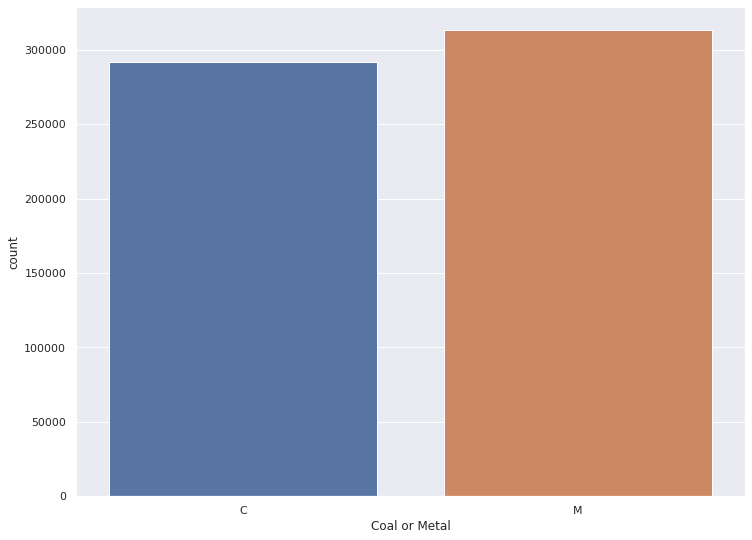

In [ ]:
# Let's see the count of accidents from coal or metal mines
# This will let us know the proportion of each category
plt.figure(figsize = (12, 9))
sns.countplot(X['Coal or Metal'])
plt.show()

We can do a classification on the source of the information as well the count of incidents from a Metal mine is in less amount in comparison to the count of the incidents from a Coal mine

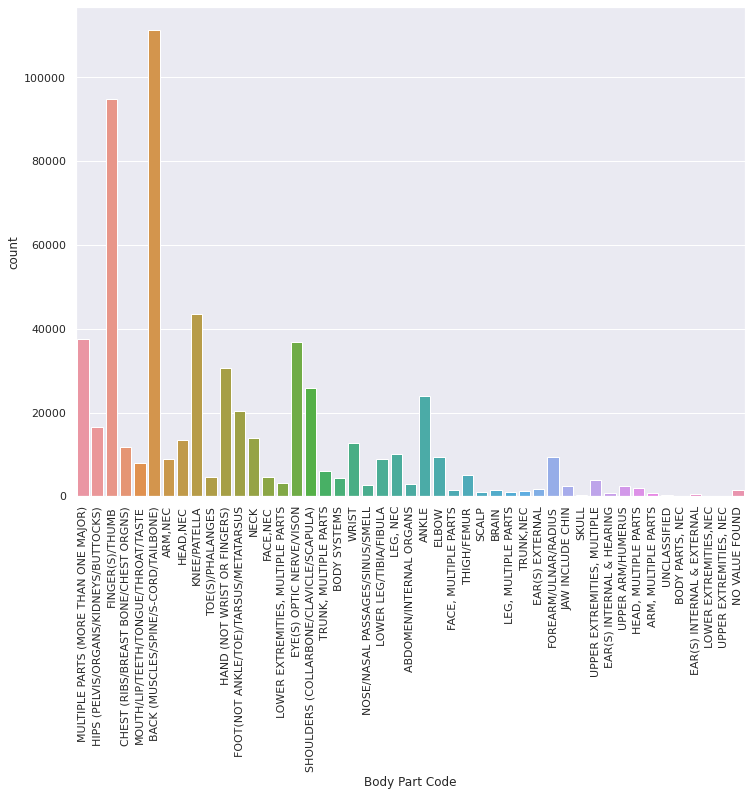

In [ ]:
# Let's see the count of times each different body part was hurt
# This will let us know the proportion of each bodypart
plt.figure(figsize = (12, 9))
sns.countplot(X['Body Part Code'])
plt.xticks(rotation=90)
plt.show()

The plot above shows that there are some body part which are being injured more often in comparison to some body parts which are listed very few times. The number of classes if we consider this column for classification as it is, will be too much so we will try to categorise the element of this columns to create a new column.

In [ ]:
## We have left first two columns and taken other columns as input features
X, y, ycm = X.iloc[:, 3].values, X.iloc[:, 7].values, X.iloc[:, 2]


In [ ]:
# get the names of unique organs
organ_names = list(set(y))
print(len(organ_names))


47


In [ ]:
# create a dictionary for the organs and the body_part_code mentioned in the data 
# we will make the dictionary so that we can change the output column easily
part_to_class = {'ABDOMEN/INTERNAL ORGANS': 'trunk',
 'ANKLE': 'limbs',
 'ARM, MULTIPLE PARTS': 'limbs',
 'ARM,NEC': 'limbs',
 'BACK (MUSCLES/SPINE/S-CORD/TAILBONE)': 'trunk',
 'BODY PARTS, NEC': 'general',
 'BODY SYSTEMS': 'general',
 'BRAIN': 'upper_neck',
 'CHEST (RIBS/BREAST BONE/CHEST ORGNS)': 'trunk',
 'EAR(S) EXTERNAL': 'upper_neck',
 'EAR(S) INTERNAL & EXTERNAL': 'upper_neck',
 'EAR(S) INTERNAL & HEARING': 'upper_neck',
 'ELBOW': 'limbs',
 'EYE(S) OPTIC NERVE/VISON': 'upper_neck',
 'FACE, MULTIPLE PARTS': 'upper_neck',
 'FACE,NEC': 'upper_neck',
 'FINGER(S)/THUMB': 'limbs',
 'FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS': 'limbs',
 'FOREARM/ULNAR/RADIUS': 'limbs',
 'HAND (NOT WRIST OR FINGERS)': 'limbs',
 'HEAD, MULTIPLE PARTS': 'upper_neck',
 'HEAD,NEC': 'upper_neck',
 'HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)': 'trunk',
 'JAW INCLUDE CHIN': 'upper_neck',
 'KNEE/PATELLA': 'limbs',
 'LEG, MULTIPLE PARTS': 'limbs',
 'LEG, NEC': 'limbs',
 'LOWER EXTREMITIES, MULTIPLE PARTS': 'limbs',
 'LOWER EXTREMITIES,NEC': 'limbs',
 'LOWER LEG/TIBIA/FIBULA': 'limbs',
 'MOUTH/LIP/TEETH/TONGUE/THROAT/TASTE': 'upper_neck',
 'MULTIPLE PARTS (MORE THAN ONE MAJOR)': 'general',
 'NECK': 'trunk',
 'NO VALUE FOUND': 'general',
 'NOSE/NASAL PASSAGES/SINUS/SMELL': 'upper_neck',
 'SCALP': 'upper_neck',
 'SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA)': 'trunk',
 'SKULL': 'upper_neck',
 'THIGH/FEMUR': 'limbs',
 'TOE(S)/PHALANGES': 'limbs',
 'TRUNK, MULTIPLE PARTS': 'trunk',
 'TRUNK,NEC': 'trunk',
 'UNCLASSIFIED': 'general',
 'UPPER ARM/HUMERUS': 'limbs',
 'UPPER EXTREMITIES, MULTIPLE': 'limbs',
 'UPPER EXTREMITIES, NEC': 'limbs',
 'WRIST': 'limbs'}
set(part_to_class.values())

{'general', 'limbs', 'trunk', 'upper_neck'}

In [ ]:
for i in range(len(y)):
  y[i] = part_to_class[y[i]]

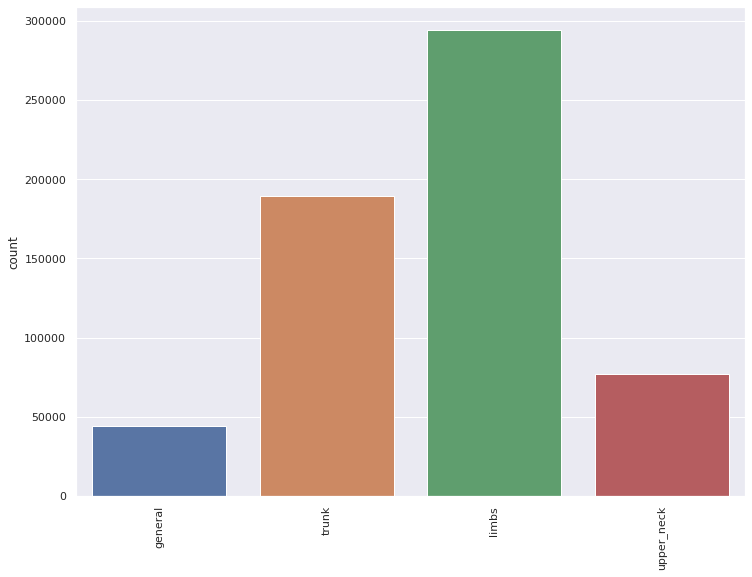

In [ ]:
# Let's see the count of times each different body part was hurt
# This will let us know the proportion of each bodypart
plt.figure(figsize = (12, 9))
sns.countplot(y)
plt.xticks(rotation=90)
plt.show()

# Onehot vectorization of target variable

In [ ]:
# We will now conver the output column into onehot encoding
# The encoded classes will be used for neural network model specially

dict_labels = {b:a for (a,b) in enumerate(set(y))}
dict_label_reverse = {b:a for (a, b) in dict_labels.items()}
Y = []
Y_oh = []

for item in y:
  temp = np.zeros(len(dict_labels))
  temp[dict_labels[item]] = 1
  Y.append(dict_labels[item])
  Y_oh.append(temp)

Y = np.array(Y)
Y_oh = np.array(Y_oh)

In [ ]:
Y_oh

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
X

array(['EMPL STANDING ON 5 GAL CAN PLACED ON DECK OF HAULER WELDING TRUCK BED WHEN CAN KICKED OUT FROM UNDER HIM AND EMPL FELL TO GROUND.',
       'SHOVELING LOOSE MATERIAL IN BELT TRACK ENTRY.SHOVEL FULL THROWN ONTO CONVEYOR BELT.ROCK ON BELT CAUGHT SHOVEL AND TURNED MAN SUDDENLY CAUSING LOWER ABDOMEN STRAIN RESULTING IN DOUBLE HERNIA.',
       'USING BUCK SAW TO CUT POST,SAW JUMPED AND STRUCK MAN ON RIGHT THUMB RESULTING IN LACERATION.',
       ...,
       'AFTER PULLING THE BELT ONT HE CONVEYOR BELT OF ROCK CRUSHER LOAST BALANCE CAUGHT HIMSELF BY THE RT HAND IN DOING SO CAUGHT HAND IN CONVEYOR BELT.',
       'EE WAS PULLING ENGINE CORD & PULLED A MUSCLE IN RT SHOULDER.',
       'SLIPPED & FELL BACKWARD OFF THE DOZER LANDING ON H IS BACK.'],
      dtype=object)

# Cleaning and conversion of the text data
The following steps will involve the cleaning of the text data, we will remove the punctuations of the text the stopwords will also be removed. We will not tokenise the data permanently because we will be using tfdif vectorization, but tokenization will be used to remove the stopwords. 
This section will also contaiin the word cloud of the data so that we can know that which words are the most important ones.

In [ ]:
# we will impor the nltk and the string libraries for dealing with the stopwords and punctuations
import nltk 
import string 
import re 

In [ ]:
# Data before the transformation
X

array(['EMPL STANDING ON 5 GAL CAN PLACED ON DECK OF HAULER WELDING TRUCK BED WHEN CAN KICKED OUT FROM UNDER HIM AND EMPL FELL TO GROUND.',
       'SHOVELING LOOSE MATERIAL IN BELT TRACK ENTRY.SHOVEL FULL THROWN ONTO CONVEYOR BELT.ROCK ON BELT CAUGHT SHOVEL AND TURNED MAN SUDDENLY CAUSING LOWER ABDOMEN STRAIN RESULTING IN DOUBLE HERNIA.',
       'USING BUCK SAW TO CUT POST,SAW JUMPED AND STRUCK MAN ON RIGHT THUMB RESULTING IN LACERATION.',
       ...,
       'AFTER PULLING THE BELT ONT HE CONVEYOR BELT OF ROCK CRUSHER LOAST BALANCE CAUGHT HIMSELF BY THE RT HAND IN DOING SO CAUGHT HAND IN CONVEYOR BELT.',
       'EE WAS PULLING ENGINE CORD & PULLED A MUSCLE IN RT SHOULDER.',
       'SLIPPED & FELL BACKWARD OFF THE DOZER LANDING ON H IS BACK.'],
      dtype=object)

In [ ]:
# Lets remove the punctuations from the data
import string
for i in range(len(X)):
  for c in string.punctuation:
      X[i]= X[i].replace(c,"")

In [ ]:
# Data after removing the punctuations from the data
X

array(['EMPL STANDING ON 5 GAL CAN PLACED ON DECK OF HAULER WELDING TRUCK BED WHEN CAN KICKED OUT FROM UNDER HIM AND EMPL FELL TO GROUND',
       'SHOVELING LOOSE MATERIAL IN BELT TRACK ENTRYSHOVEL FULL THROWN ONTO CONVEYOR BELTROCK ON BELT CAUGHT SHOVEL AND TURNED MAN SUDDENLY CAUSING LOWER ABDOMEN STRAIN RESULTING IN DOUBLE HERNIA',
       'USING BUCK SAW TO CUT POSTSAW JUMPED AND STRUCK MAN ON RIGHT THUMB RESULTING IN LACERATION',
       ...,
       'AFTER PULLING THE BELT ONT HE CONVEYOR BELT OF ROCK CRUSHER LOAST BALANCE CAUGHT HIMSELF BY THE RT HAND IN DOING SO CAUGHT HAND IN CONVEYOR BELT',
       'EE WAS PULLING ENGINE CORD  PULLED A MUSCLE IN RT SHOULDER',
       'SLIPPED  FELL BACKWARD OFF THE DOZER LANDING ON H IS BACK'],
      dtype=object)

In [ ]:
# Import the english stopwords so that we can remove all the stopwords of english language
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [ ]:

ENGLISH_STOP_WORDS = set(ENGLISH_STOP_WORDS)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
stop_words.update(ENGLISH_STOP_WORDS)

In [ ]:
# Following line of codes will help us remove all te stopwords based on the stopwords in stop_words variable
# We will also conver all the words into lower case for simplicity


def remove_stopwords(text):  
    word_tokens = word_tokenize(text) 
    filtered_text =  ' '.join([word.lower() for word in word_tokens if word.lower() not in stop_words])
    return filtered_text 

In [ ]:
# Now lets call above defined remove_stopwords function to remove the stopwords
for i in range(len(X)):
    X[i] = remove_stopwords(X[i])

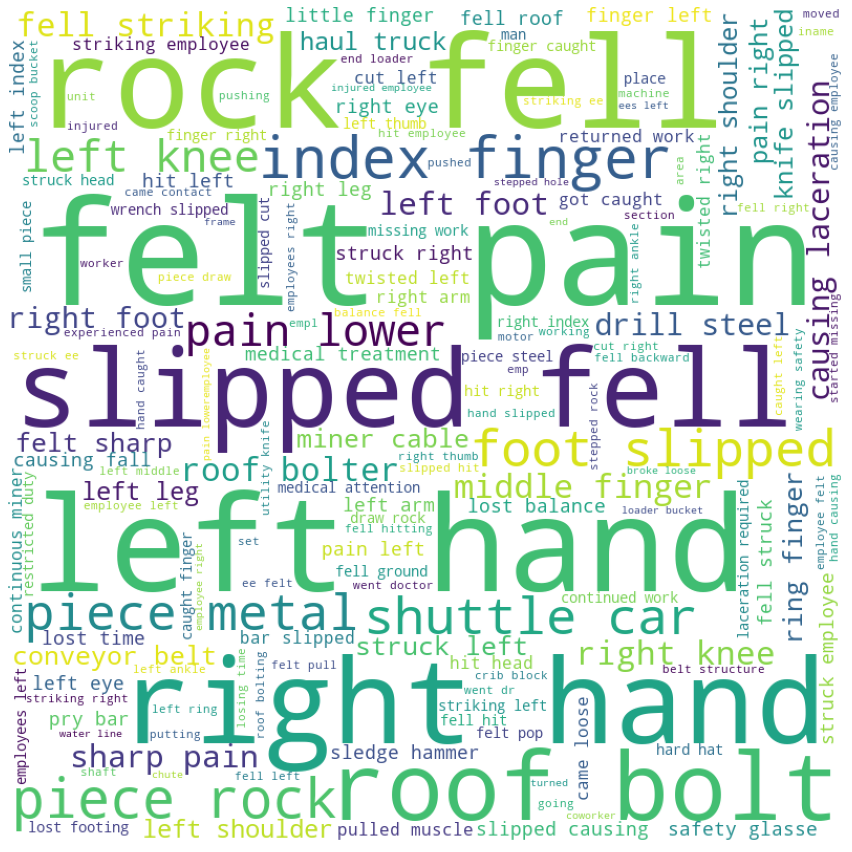

In [ ]:
all_words = ''
for x in X:
  all_words += x

cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(all_words)
                

  
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout()
  
plt.show()


In [ ]:
X

array(['empl standing 5 gal placed deck hauler welding truck bed kicked empl fell ground',
       'shoveling loose material belt track entryshovel thrown conveyor beltrock belt caught shovel turned man suddenly causing lower abdomen strain resulting double hernia',
       'using buck saw cut postsaw jumped struck man right thumb resulting laceration',
       ...,
       'pulling belt ont conveyor belt rock crusher loast balance caught rt hand caught hand conveyor belt',
       'ee pulling engine cord pulled muscle rt shoulder',
       'slipped fell backward dozer landing h'], dtype=object)

In [ ]:
# The multihot vectorization will not be a good choice since we dont have enougnh memory for that case
# So we will use TFIDF vectoriser for the vectorization of the sentenses
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  
X = tfidfconverter.fit_transform(X).toarray()


In [ ]:
# X_words = set()

# for item in X:
#   X_words = X_words.union(set(item))

# X_words = list(X_words)

In [ ]:
# len(X_words)

In [ ]:
# id_to_word = {a:b for (a, b) in enumerate(X_words)}

In [ ]:
# word_to_id = {b:a for a, b in id_to_word.items()}

In [ ]:
# word_to_id

In [ ]:
# X_mh = np.zeros((len(X), 10000))
# for i in range(len(X)):
#   temp = np.zeros(10000)
#   for x in X[i]:
#     try:
#       temp[word_to_id[x]] = 1
#     except:
#       pass
#   X_mh[i] = temp

# X = X_mh


In [ ]:
Y_oh

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X.shape

(604733, 2000)

In [ ]:
# Now we will split the data into two sets one for trainig and one for testing
# The fraction of testinf set is about 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, test_size = 0.20, random_state = 0)

In [ ]:
# def multi_hot_encode(sequences, dimension):
    
#     results = np.zeros((len(sequences), dimension))
#     for i in range(len(sequences)):
#         for j in range(len(sequences[i])):
#             results[i][sequences[i][j]] = 1
#     return results


In [ ]:
# x_train = multi_hot_encode(X_train, 6789)
# x_test = multi_hot_encode(X_test, 6789)

In [ ]:
# x_train.shape

## Build Model

The models which are built are
* Random forest classifier
* Logistic regression
* Deep Neural Network

In [ ]:
#x_strat.shape
X_train.shape

(34101, 2000)

In [ ]:
y_test, y_train = Y_test.argmax(axis = 1), Y_train.argmax(axis = 1)

## Random forest classifier

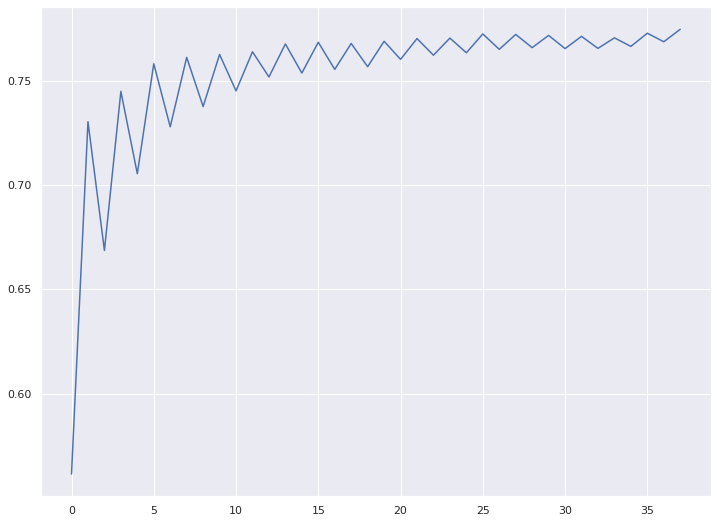

In [ ]:
# We will try to find out the best value of number of estimaters using this technique

acc_list = []

for i in range(2, 40):
  text_classifier = RandomForestClassifier(n_estimators=i, random_state=0)
  text_classifier.fit(X_train, Y_train)
  predictions = text_classifier.predict(X_test)
  acc_list.append(accuracy_score(Y_test, predictions))


plt.figure(figsize = (12, 9))
plt.plot(acc_list)
plt.show()

From the result it is clearly visible that the model gets better and better as we increase the number of estimaters.

In [ ]:
# Now we will try to find out the overall best parameters for the model

from sklearn.model_selection import RandomizedSearchCV

parameters = {'bootstrap': [True, False],
              'max_depth': [40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [i for i in range(20, 40)]}


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 50.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
def get_results(pred, model):
  print(classification_report(y_test, pred))

  prob_pred_test = model.predict_proba(X_test)[:, 1]
  prob_pred_train = model.predict_proba(X_train)[:, 1]

  # print('\n\n\nThe ROC AUC score is shown below')
  # print(roc_auc_score(Y_test.argmax(axis=1), prob_pred_test))

  print('\n\n\nThe following matrix show the confusion matrix')
  print(confusion_matrix(y_test, pred))
  plot_confusion_matrix(model, X_test, y_test)
  plt.show()

  print('\n\n\nModel score is printed below')
  print(model.score(X_test, y_test))

In [ ]:
# The best parameters of the model are shown below
rf_random.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 29}

In [ ]:
# Now we will create the final 
text_classifier = RandomForestClassifier(bootstrap = False,
                                          max_depth = None,
                                          max_features = 'sqrt',
                                          min_samples_leaf = 1,
                                          min_samples_split = 10,
                                          n_estimators = 39)  
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=39,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       0.77      0.36      0.49      1025
           1       0.69      0.35      0.47       322
           2       0.82      0.96      0.88      5553
           3       0.78      0.65      0.70      1626

    accuracy                           0.81      8526
   macro avg       0.76      0.58      0.64      8526
weighted avg       0.80      0.81      0.79      8526




The following matrix show the confusion matrix
[[ 374   35  500  116]
 [  24  113  156   29]
 [  49   14 5333  157]
 [  40    1  536 1049]]


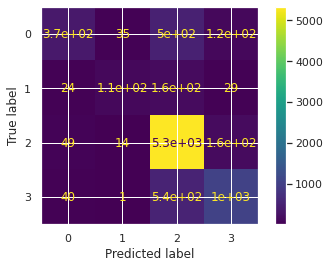




Model score is printed below
0.805653295801079


In [ ]:
predictions = text_classifier.predict(X_test)
 
 
get_results(predictions, text_classifier)

In [ ]:
text_classifier_lr = LogisticRegression()

text_classifier_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.69      0.38      0.49      1025
           1       0.74      0.30      0.43       322
           2       0.81      0.96      0.88      5553
           3       0.77      0.61      0.68      1626

    accuracy                           0.80      8526
   macro avg       0.75      0.56      0.62      8526
weighted avg       0.79      0.80      0.78      8526




The following matrix show the confusion matrix
[[ 385   27  497  116]
 [  38   98  158   28]
 [  83    6 5312  152]
 [  52    2  579  993]]


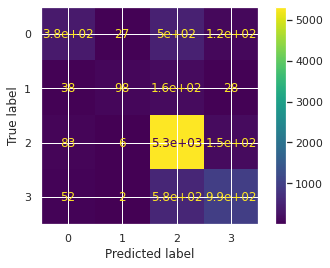




Model score is printed below
0.7961529439361952


In [ ]:
predictions = text_classifier_lr.predict(X_test)

get_results(predictions, text_classifier_lr)


In [ ]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])


param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(30,101,10))}
]


clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)


best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 18.8min finished


              precision    recall  f1-score   support

           0       0.76      0.87      0.81      3919
           1       0.75      0.76      0.75      3024
           2       0.74      0.33      0.45       913
           3       0.80      0.67      0.73       670

    accuracy                           0.76      8526
   macro avg       0.76      0.66      0.69      8526
weighted avg       0.76      0.76      0.75      8526




The following matrix show the confusion matrix
[[3404  422   45   48]
 [ 623 2299   50   52]
 [ 332  273  297   11]
 [ 139   76    8  447]]


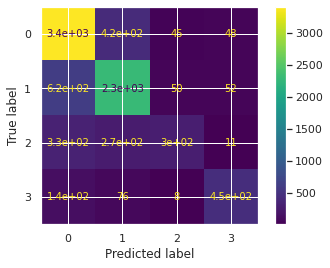




Model score is printed below
0.7561576354679803


In [ ]:
predictions = best_clf.predict(X_test)

get_results(predictions, best_clf)


In [ ]:
def create_model():
    """
    Output:
        model: A compiled keras model
    """
    model = Sequential()
    model.add(Embedding(500, 32, input_length = X_train.shape[1]))
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model
  
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          16000     
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 512008    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
Total params: 528,116
Trainable params: 528,116
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import matplotlib.pyplot as plt
def fit(model):
    """
    Action:
        Fit the model created above using training data as x_strat and y_strat
        and validation_data as x_dev and y_dev, verbose=2 and store it in 'history' variable.
        
        evaluate the model using x_test, y_test, verbose=0 and store it in 'scores' list
    Output:
        scores: list of length 2
        history_dict: output of history.history where history is output of model.fit()
    """

    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=1000, verbose=1)
    scores =  model.evaluate(X_test, Y_test, verbose=0)
    history_dict = history.history
    return scores,history_dict
    
scores,history_dict = fit(model)    


Epoch 1/50
35/35 [==============================] - 24s 279ms/step - loss: 1.1533 - accuracy: 0.6548 - val_loss: 0.9920 - val_accuracy: 0.6513
Epoch 2/50
35/35 [==============================] - 9s 267ms/step - loss: 0.9810 - accuracy: 0.6531 - val_loss: 0.9785 - val_accuracy: 0.6513
Epoch 3/50
35/35 [==============================] - 9s 267ms/step - loss: 0.9783 - accuracy: 0.6482 - val_loss: 0.9755 - val_accuracy: 0.6513
Epoch 4/50
35/35 [==============================] - 9s 266ms/step - loss: 0.9748 - accuracy: 0.6495 - val_loss: 0.9747 - val_accuracy: 0.6513
Epoch 5/50
35/35 [==============================] - 9s 266ms/step - loss: 0.9705 - accuracy: 0.6511 - val_loss: 0.9738 - val_accuracy: 0.6513
Epoch 6/50
35/35 [==============================] - 9s 267ms/step - loss: 0.9689 - accuracy: 0.6508 - val_loss: 0.9739 - val_accuracy: 0.6513
Epoch 7/50
35/35 [==============================] - 9s 267ms/step - loss: 0.9635 - accuracy: 0.6533 - val_loss: 0.9739 - val_accuracy: 0.6513
Epoch

In [ ]:
Accuracy=scores[1]*100
print('Accuracy of your model is')
print(scores[1]*100)

Accuracy of your model is
65.1301920413971


In [ ]:
# history_dict

### Verify whether training in converged or not

<Figure size 432x288 with 0 Axes>

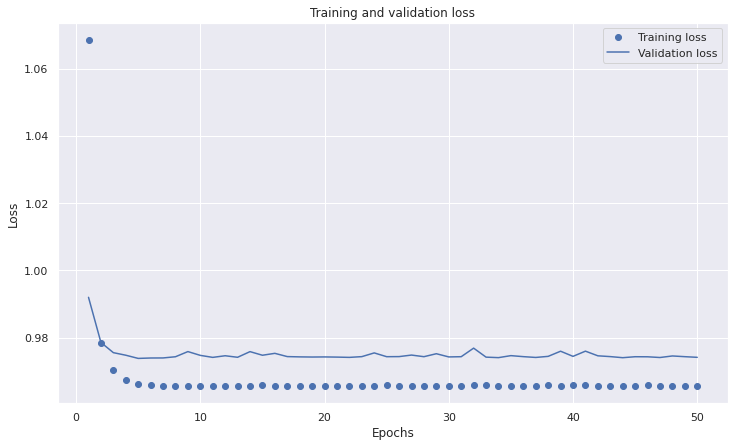

In [ ]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize = (12, 7))
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Findings
 
The problem statement was to classify the incident narration into one of the body part injured from four major body parts. The total body parts mentioned in the dataset were 47 but that would have been a problem as the number of classes would be too much. So, I categorised all those 47 classes into four major categories. The name of the categories are mentioned below.
* **upper_neck** : upper neck category contained all the injuries which were above the neck of the person.
* **trunk** : trunk category contains all the injuries except for limbs and the upper neck
* **limbs** : limbs category contains all the injuries which are occuring on the hands or the legs on the person.
* **general** : all the injuries which are either not specified or are specified as general will be contained by general category
 
The main task was to classify te text into one of the four classes. The dataset was pretty long so the converson of the text values into normal multihot encoding was not helping so, I used the TFIDF vectorisation for it and limited the length of the vectors to 2000 only. But before the conversion I had to clean the data.
 
Cleaning the data consisted of removing all the punctuations and all the stopwords from the data, since the punctuations and the stopwords do not contribute a lot to the meaning of the text. After the data was cleaned then we converted them to vectors. Similarly we had to keep two different versions of the dependent variable one for classical models like logistic regression and the random forests and another for the Neural networks. The neural networks version of the dependent variable was converted to one hot vectors.
 
# performance of the models
Out of the three classical models which we made the performance of of logistic regression world's most practical as apart from being accurate it was also faster than the random forest classifier and the combination of elastic regression and random forest classifier.
In case of the neural network the findings were completely not expected as even the loss of the model was continuously decreasing while training the accuracy did not change at all. The overall validation accuracy we got in the neural network model was less than all of the classical models. 
 
# major problems
The major problem we faced while the whole analysis what's the fat that the data set was too large and it's vectorisation was causing the runtime to crash, multi hot vectorisation technique din workout so we went for tf-idf factorization.